In [ ]:
!pip install torch torchvision torchaudio

# Install Faiss
!conda install -c pytorch faiss-cpu

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 18.7 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np
import time
from types import SimpleNamespace

import faiss

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import auc as compute_area_under_curve

In [ ]:
try:
    import torch
    FOUND_TORCH = True
except (ImportError, ModuleNotFoundError):
    FOUND_TORCH = False

try:
    import transformers
    FOUND_TRANSFORMERS = True
except (ImportError, ModuleNotFoundError):
    FOUND_TRANSFORMERS = False

if FOUND_TORCH and FOUND_TRANSFORMERS:
    # only needed for tokenizing
    from utils import get_tokenizer, get_model, featurize_tokens_from_model, get_device_from_arg


MODEL, TOKENIZER, MODEL_NAME = None, None, None

In [ ]:
def compute_mauve(
        p_features=None, q_features=None,
        p_tokens=None, q_tokens=None,
        p_text=None, q_text=None,
        num_buckets='auto', pca_max_data=-1, kmeans_explained_var=0.9,
        kmeans_num_redo=5, kmeans_max_iter=500,
        featurize_model_name='gpt2-large', device_id=-1, max_text_length=1024,
        divergence_curve_discretization_size=25, mauve_scaling_factor=5,
        verbose=False, seed=25, batch_size=1, use_float64=False,
):

    if p_features is None and p_tokens is None and p_text is None:
        raise ValueError('Supply at least one of p_features, p_tokens, p_text')
    if q_features is None and q_tokens is None and q_text is None:
        raise ValueError('Supply at least one of q_features, q_tokens, q_text')
    p_features = get_features_from_input(
        p_features, p_tokens, p_text, featurize_model_name, max_text_length,
        device_id, name="p", verbose=verbose, batch_size=batch_size, use_float64=use_float64,
    )
    q_features = get_features_from_input(
        q_features, q_tokens, q_text, featurize_model_name, max_text_length,
        device_id, name="q", verbose=verbose, batch_size=batch_size, use_float64=use_float64,
    )
    if num_buckets == 'auto':
        # heuristic: use num_clusters = num_generations / 10
        num_buckets = max(2, int(round(min(p_features.shape[0], q_features.shape[0]) / 10)))
    elif not isinstance(num_buckets, int):
        raise ValueError('num_buckets is expected to be an integer or "auto"')

    # Acutal binning
    t1 = time.time()
    p, q = cluster_feats(p_features, q_features,
                         num_clusters=num_buckets,
                         norm='l2', whiten=False,
                         pca_max_data=pca_max_data,
                         explained_variance=kmeans_explained_var,
                         num_redo=kmeans_num_redo,
                         max_iter=kmeans_max_iter,
                         seed=seed, verbose=verbose)
    t2 = time.time()
    if verbose:
        print('total discretization time:', round(t2-t1, 2), 'seconds')

    # Divergence curve and mauve
    mixture_weights = np.linspace(1e-6, 1-1e-6, divergence_curve_discretization_size)
    divergence_curve = get_divergence_curve_for_multinomials(p, q, mixture_weights, mauve_scaling_factor)
    x, y = divergence_curve.T
    idxs1 = np.argsort(x)
    idxs2 = np.argsort(y)
    mauve_score = 0.5 * (
        compute_area_under_curve(x[idxs1], y[idxs1]) +
        compute_area_under_curve(y[idxs2], x[idxs2])
    )
    fi_score = get_fronter_integral(p, q)
    to_return = SimpleNamespace(
        p_hist=p, q_hist=q, divergence_curve=divergence_curve,
        mauve=mauve_score,
        frontier_integral=fi_score,
        num_buckets=num_buckets,
    )
    return to_return

In [ ]:
def get_features_from_input(features, tokenized_texts, texts,
                            featurize_model_name, max_len, device_id, name, batch_size,
                            verbose=False, use_float64=False):
    global MODEL, TOKENIZER, MODEL_NAME
    if features is None:
        # Featurizing is necessary. Make sure the required packages are available
        if not FOUND_TORCH:
            raise ModuleNotFoundError(
                """PyTorch not found. Please install PyTorch if you would like to use the featurization.
                    For details, see `https://github.com/krishnap25/mauve`
                    and `https://pytorch.org/get-started/locally/`.
                """)
        if not FOUND_TRANSFORMERS:
            raise ModuleNotFoundError(
                """Transformers not found. Please install Transformers if you would like to use the featurization.
                    For details, see `https://github.com/krishnap25/mauve`
                    and `https://huggingface.co/transformers/installation.html`.
                """)

        if tokenized_texts is None:
            # tokenize texts
            if TOKENIZER is None or MODEL_NAME != featurize_model_name:
                if verbose: print('Loading tokenizer')
                TOKENIZER = get_tokenizer(featurize_model_name)
            if verbose: print('Tokenizing text...')
            tokenized_texts = [
                TOKENIZER.encode(sen, return_tensors='pt', truncation=True, max_length=max_len)
                for sen in texts
            ]
        # use tokenized_texts to featurize
        if TOKENIZER is None or MODEL_NAME != featurize_model_name:
            if verbose: print('Loading tokenizer')
            TOKENIZER = get_tokenizer(featurize_model_name)
        if MODEL is None or MODEL_NAME != featurize_model_name:
            if verbose: print('Loading model')
            MODEL = get_model(featurize_model_name, TOKENIZER, device_id)
            MODEL_NAME = featurize_model_name
        else:
            MODEL = MODEL.to(get_device_from_arg(device_id))
        if use_float64:
            MODEL = MODEL.double()
        if verbose: print('Featurizing tokens')
        features = featurize_tokens_from_model(MODEL, tokenized_texts, batch_size, name).detach().cpu().numpy()
    else:
        features = np.asarray(features)
    return features


In [ ]:
def cluster_feats(p, q, num_clusters,
                  norm='none', whiten=True,
                  pca_max_data=-1,
                  explained_variance=0.9,
                  num_redo=5, max_iter=500,
                  seed=0, verbose=False):
    assert 0 < explained_variance < 1
    if verbose:
        print(f'seed = {seed}')
    assert norm in ['none', 'l2', 'l1', None]
    data1 = np.vstack([q, p])
    if norm in ['l2', 'l1']:
        data1 = normalize(data1, norm=norm, axis=1)
    pca = PCA(n_components=None, whiten=whiten, random_state=seed+1)
    if pca_max_data < 0 or pca_max_data >= data1.shape[0]:
        pca.fit(data1)
    elif 0 < pca_max_data < data1.shape[0]:
        rng = np.random.RandomState(seed+5)
        idxs = rng.choice(data1.shape[0], size=pca_max_data, replace=False)
        pca.fit(data1[idxs])
    else:
        raise ValueError(f'Invalid argument pca_max_data={pca_max_data} with {data1.shape[0]} datapoints')
    s = np.cumsum(pca.explained_variance_ratio_)
    idx = np.argmax(s >= explained_variance)  # last index to consider
    if verbose:
        print(f'performing clustering in lower dimension = {idx}')
    data1 = pca.transform(data1)[:, :idx+1]
    # Cluster
    data1 = data1.astype(np.float32)
    t1 = time.time()
    kmeans = faiss.Kmeans(data1.shape[1], num_clusters, niter=max_iter,
                          verbose=verbose, nredo=num_redo, update_index=True,
                          seed=seed+2)
    kmeans.train(data1)
    _, labels = kmeans.index.search(data1, 1)
    labels = labels.reshape(-1)
    t2 = time.time()
    if verbose:
        print('kmeans time:', round(t2-t1, 2), 's')

    q_labels = labels[:len(q)]
    p_labels = labels[len(q):]

    q_bins = np.histogram(q_labels, bins=num_clusters,
                           range=[0, num_clusters], density=True)[0]
    p_bins = np.histogram(p_labels, bins=num_clusters,
                          range=[0, num_clusters], density=True)[0]


    return p_bins / p_bins.sum(), q_bins / q_bins.sum()


In [ ]:
def kl_multinomial(p, q):
    assert p.shape == q.shape
    if np.logical_and(p != 0, q == 0).any():
        return np.inf
    else:
        idxs = np.logical_and(p != 0, q != 0)
        return np.sum(p[idxs] * np.log(p[idxs] / q[idxs]))


In [ ]:
def get_divergence_curve_for_multinomials(p, q, mixture_weights, scaling_factor):
    # TODO: check if extreme points are needed
    divergence_curve = [[0, np.inf]] # extreme point
    for w in np.sort(mixture_weights):
        r = w * p + (1 - w) * q
        divergence_curve.append([kl_multinomial(q, r), kl_multinomial(p, r)])
    divergence_curve.append([np.inf, 0]) # other extreme point
    return np.exp(-scaling_factor * np.asarray(divergence_curve))


In [ ]:
def get_fronter_integral(p, q, scaling_factor=2):
    total = 0.0
    for p1, q1 in zip(p, q):
        if p1 == 0 and q1 == 0:
            pass
        elif p1 == 0:
            total += q1 / 4
        elif q1 == 0:
            total += p1 / 4
        elif abs(p1 - q1) > 1e-8:
            t1 = p1 + q1
            t2 = p1 * q1 * (math.log(p1) - math.log(q1)) / (p1 - q1)
            total += 0.25 * t1 - 0.5 * t2
        # else: contribution is 0
    return total * scaling_factor

In [ ]:
!python examples/download_gpt2_dataset.py

Fetching amazon.valid.jsonl: 4.66Mit [00:01, 2.71Mit/s]                                             
Fetching amazon-xl-1542M.valid.jsonl: 4.62Mit [00:01, 2.70Mit/s]                                    


In [ ]:
from examples import load_gpt2_dataset
p_text = load_gpt2_dataset('data/amazon.valid.jsonl', num_examples=100) # human
q_text = load_gpt2_dataset('data/amazon-xl-1542M.valid.jsonl', num_examples=100) # machine

In [ ]:
out = compute_mauve(p_text=p_text, q_text=q_text, device_id=0, max_text_length=256, verbose=True)
print(out.mauve) # prints 0.9917

Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/100 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/100 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 80
kmeans time: 0.41 s
total discretization time: 0.45 seconds
0.991679398536574


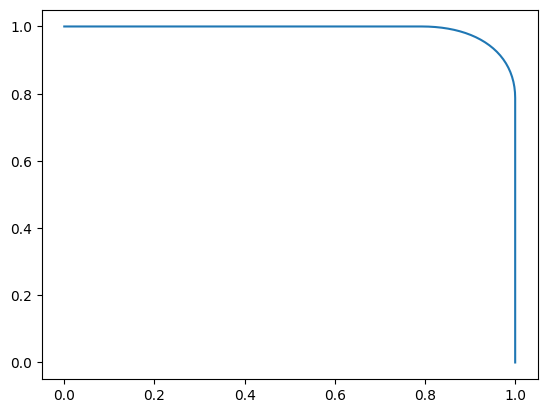

In [ ]:
import matplotlib.pyplot as plt
plt.plot(out.divergence_curve[:, 1], out.divergence_curve[:, 0])

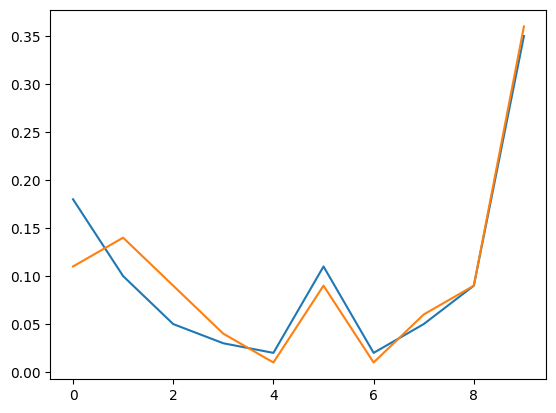

In [ ]:
out.q_hist
plt.plot(out.q_hist)
plt.plot(out.p_hist)

In [ ]:
def kl_multinomial(p, q):
    assert p.shape == q.shape
    # Compute Jaccard similarity instead of KL divergence
    intersection = np.minimum(p, q).sum()
    union = np.maximum(p, q).sum()
    jaccard_similarity = intersection / union
    return 1 - jaccard_similarity

In [ ]:
result = compute_mauve(
    p_text=["quick lazy dog.",
            "A brown fox jumps over a lazy dog.",
            "The fast fox jumps over the lazy dog."],  # First dataset
    q_text=[ "The moon rises slowly over the darkened horizon.",
             "Chess is a strategic board game enjoyed by millions worldwide.",
             "Newton's laws of motion describe the relationship between an object's motion and the forces acting on it."]  ,# Second dataset
    verbose=True  # Print progress updates
)


# Retrieve the MAUVE score from the result
mauve_score = result.mauve
print("MAUVE score between the two dissimilar datasets:", mauve_score)


Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/3 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/3 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 3
kmeans time: 0.05 s
total discretization time: 0.06 seconds
MAUVE score between the two dissimilar datasets: 0.01987109792614232


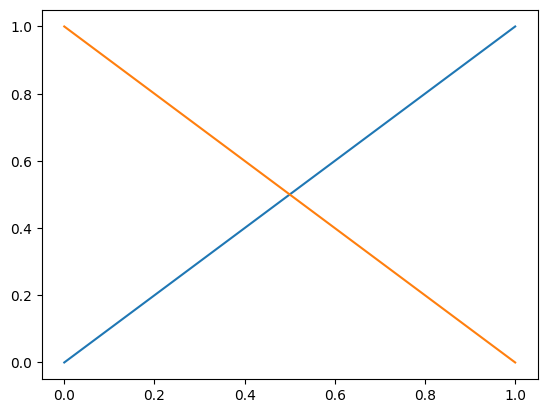

In [ ]:
import matplotlib.pyplot as plt
result.q_hist
plt.plot(result.q_hist)
plt.plot(result.p_hist)

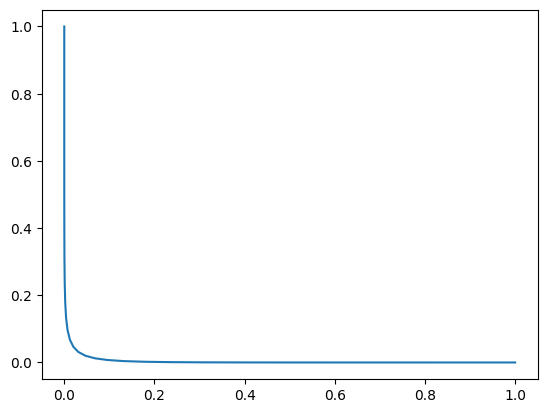

In [ ]:
import matplotlib.pyplot as plt
plt.plot(result.divergence_curve[:, 1], result.divergence_curve[:, 0])

In [ ]:
result = compute_mauve(
    p_text=["quick lazy dog.",
            "A brown fox jumps over a lazy dog.",
            "The fast fox jumps over the lazy dog."],  # First dataset
    q_text=[ "The moon rises slowly over the darkened horizon.",
             "A brown fox jumps over a lazy dog.",
            "The fast fox jumps over the lazy dog."]  ,# Second dataset
    verbose=True  # Print progress updates
)


# Retrieve the MAUVE score from the result
mauve_score = result.mauve
print("MAUVE score between the two dissimilar datasets:", mauve_score)

Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/3 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/3 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 2
kmeans time: 0.13 s
total discretization time: 0.15 seconds
MAUVE score between the two dissimilar datasets: 0.5182012478497631


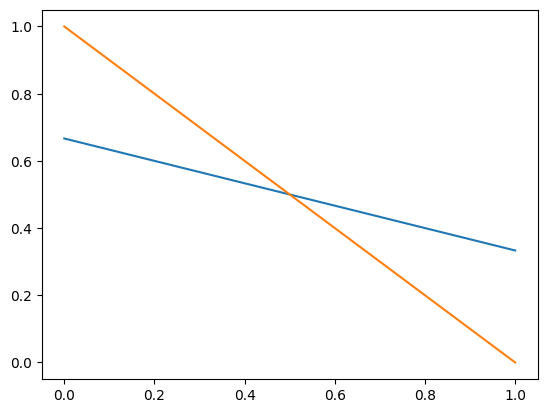

In [ ]:
import matplotlib.pyplot as plt
result.q_hist
plt.plot(result.q_hist)
plt.plot(result.p_hist)

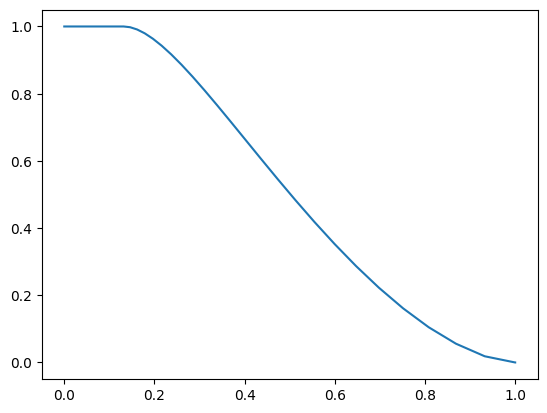

In [ ]:
import matplotlib.pyplot as plt
plt.plot(result.divergence_curve[:, 1], result.divergence_curve[:, 0])